In [1]:
import os
import sys
dir_project = os.path.dirname(os.getcwd())
path = os.path.join(dir_project, 'src')
if path not in sys.path:
    sys.path.append(path)

current_directory = os.getcwd()
#os.chdir(os.path.join(dir_project, 'src'))
print("Current Working Directory:", os.getcwd())

Current Working Directory: c:\Users\nilsh\my_projects\SeqLP\jupyter_scripts


In [8]:
import pandas as pd
from seqlp.visualize.supervised_ml import DataPipeline
import glob

In [3]:
Data = DataPipeline(model = r"C:\Users\nilsh\my_projects\ExpoSeq\models\nanobody_full",
             path_seq_report = r"C:\Users\nilsh\my_projects\ExpoSeq\my_experiments\max_new\sequencing_report.csv",
             no_sequences = 100,  # take basically all sequences
             pca_components=40)


Some weights of EsmModel were not initialized from the model checkpoint at C:\Users\nilsh\my_projects\ExpoSeq\models\nanobody_full and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\nilsh\my_projects\SeqLP\src\seqlp\visualize\supervised_ml.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequencing_report[['full_sequence', 'CDRPositions']] = sequencing_report.apply(ExtractData.calculate_cdr_positions, axis=1, result_type='expand')
c:\Users\nilsh\my_projects\SeqLP\src\seqlp\visualize\supervised_ml.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Explained variance after reducing to 40 dimensions:0.9936172366142273


In [10]:
sequencing_report = Data.init_sequencing_report
sequencing_report["v_gene"] = sequencing_report['allVHitsWithScore'].str.split('*').str[0]
experiments = sequencing_report["Experiment"].unique().tolist()
v_family = sequencing_report["v_gene"].tolist()
sequencing_report["full_seq"] = Data.full_sequences
print(f"No. of sequences in report: {sequencing_report.shape[0]}")

No. of sequences in report: 700


In [5]:
training_data = pd.read_csv(r'c:\Users\nilsh\OneDrive\Desktop\master_thesis\train_model\concatenatednanobody_full_train.csv.gz', compression='gzip')
sequences = training_data.iloc[:, 0]
sequences = sequences.str.replace(' ', '')
print(f"No. of training sequences: {training_data.shape[0]}")


No. of training sequences: 3609808


In [6]:
mask = sequencing_report['full_seq'].isin(sequences)

# Step 4: Filter the DataFrame
sequencing_report = sequencing_report[~mask]
print(f"No. of sequences in report after filtering training sequences: {sequencing_report.shape[0]}")

No. of sequences in report after filtering training sequences: 700


### Perplexity Analysis

The goal is to find a metric which captures how decisive or confused the model is. We will use perplexity for this which is 2 ** Entropy.
The highest entropy for this task is 20. That means that each amino acid per position can appear with equal probability which is very bad.

Cons of this metric:
- not good for final evaluation, since it just measures the model's confidence not its accuracy
- A model with a lower perplexity can still be worse because it can just be very decisive but then in the clsutering would kinda fail to represent the sequences meaningfully.

-> your model does not output logits, so it does not really make sense to do that

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_perplexity(perplexities):
    mean_perplexity = np.mean(perplexities)
    median_perplexity = np.median(perplexities)
    std_dev = np.std(perplexities)

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.hist(perplexities, bins=30, alpha=0.7, color='blue', label='Perplexity')
    plt.axvline(mean_perplexity, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_perplexity:.2f}')
    plt.axvline(median_perplexity, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_perplexity:.2f}')
    plt.title('Distribution of Perplexity Scores')
    plt.xlabel('Perplexity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:
from seqlp.visualize.load_model import LoadModel

NanobodyModel = LoadModel(r"C:\Users\nilsh\my_projects\ExpoSeq\models\nanobody_full")
sequences = sequencing_report["full_seq"].tolist()
perplexities = []
for sequence in sequences:
    perplexity = NanobodyModel._get_perplexity(sequence)
    perplexities.append(perplexity)
perplexities = np.array(perplexities)



## Ideas for metrics

- google exponentiated cross entropy

## Ideas for clustering

- Show how model clusters nanobodies with binding data. This model should do that gradually while the others should have problems with that


Prepare binding data:

In [10]:
binding_data = pd.read_excel(r"c:\Users\nilsh\OneDrive\Desktop\MA_STX19.xlsx", sheet_name = "MA_STX19")
binding_data.head(10)
sequence_path = r"C:\Users\nilsh\OneDrive\Desktop\master_thesis\binding_data\RE_ binding data from Discovery of broadly neutralizing nanobodies using designed consensus antigens\Nanobody sequences\Sequences"
all_paths = glob.glob(sequence_path + "/*.fas")


['C:\\Users\\nilsh\\OneDrive\\Desktop\\master_thesis\\binding_data\\RE_ binding data from Discovery of broadly neutralizing nanobodies using designed consensus antigens\\Nanobody sequences\\Sequences\\MA_STX18_A11_M13rev-29-A01.fas',
 'C:\\Users\\nilsh\\OneDrive\\Desktop\\master_thesis\\binding_data\\RE_ binding data from Discovery of broadly neutralizing nanobodies using designed consensus antigens\\Nanobody sequences\\Sequences\\MA_STX18_A12_M13rev-29-A02.fas',
 'C:\\Users\\nilsh\\OneDrive\\Desktop\\master_thesis\\binding_data\\RE_ binding data from Discovery of broadly neutralizing nanobodies using designed consensus antigens\\Nanobody sequences\\Sequences\\MA_STX18_B06_M13rev-29-A03.fas',
 'C:\\Users\\nilsh\\OneDrive\\Desktop\\master_thesis\\binding_data\\RE_ binding data from Discovery of broadly neutralizing nanobodies using designed consensus antigens\\Nanobody sequences\\Sequences\\MA_STX18_B07_M13rev-29-A04.fas',
 'C:\\Users\\nilsh\\OneDrive\\Desktop\\master_thesis\\binding_da

In [12]:
from Bio import SeqIO

def read_fasta_files(directory):
    data = {'Header': [], 'Sequence': []}  # Initialize a dictionary to hold data

    # Iterate through every file in the directory
    for filename in glob.glob(directory + "/*.fas"):
        if filename.endswith(".fas"):  # Check if the file is a FASTA file
            filepath = os.path.join(directory, filename)
            for record in SeqIO.parse(filepath, "fasta"):
                data['Header'].append(record.id)       # Append the header to the Header list
                data['Sequence'].append(str(record.seq))  # Append the sequence to the Sequence list

    # Convert the dictionary into a pandas DataFrame
    df = pd.DataFrame(data)
    return df

sequences = read_fasta_files(sequence_path)
sequences.head(10)

,Header,Sequence
0,MA_STX18_A11_M13rev-29-A01,cctgtgggtGCAATTCTATTTCAaGGGAGACAGTCATAATGAAAAA...
1,MA_STX18_A12_M13rev-29-A02,ccagCTGctgCAaTTCTATTttcaaGGGAGACAGTCaTaATGAAAa...
2,MA_STX18_B06_M13rev-29-A03,ccccctGctGCAATTCTATTTtcaaGGgAagAacAGTccaTaAATG...
3,MA_STX18_B07_M13rev-29-A04,acaGCTGctGCAATTCTATTTCAaGGAGACAGTCATAATGAAAAAG...
4,MA_STX18_B10_M13rev-29-A05,cctggtggtGcaAATTCTATTTCAaGGGAGAcAGTCATAATGAAAA...
5,MA_STX18_B11_M13rev-29-A06,cccgcTGgtGCAATTCTATTTCAaGGGAGAcAGTCATAATGAAAAA...
6,MA_STX18_B12_M13rev-29-A07,cccgtTGctGCAATTCTATTTCAaGGAGACAGTCATAATGAAAAAG...
7,MA_STX18_C05_M13rev-29-A08,cccgCtgggCAATTCTATTTCAGGGAGAcAGTCATAATGAAAAAGA...
8,MA_STX18_C06_M13rev-29-A09,atttgCtggtGCAATTCTATTTCAaGGAGACAGTCATAAATGAAAA...
9,MA_STX18_C07_M13rev-29-A10,cctgctGctGCAATTCTATTTCAaGGGAGACAGTCATaATGAAAAA...


In [11]:
from seqlp.visualize.tidy_protbert_embedding import TransformerBased 
results, reduced_dim = TransformerBased.do_umap(Data.sequences_array, n_neighbors=15, min_dist = 0.2, random_seed = 42, n_components=2, metric="euclidean")

c:\Users\nilsh\my_projects\SeqLP\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
results["v_gene"] =  v_family
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
results["v_gene_encoded"] = le.fit_transform(results["v_gene"])

C:\Users\nilsh\AppData\Local\Temp\ipykernel_22496\3057312266.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(results["UMAP_1"][mask], results["UMAP_2"][mask],cmap = "tab20",  color=colors[i], label=category, s=10)


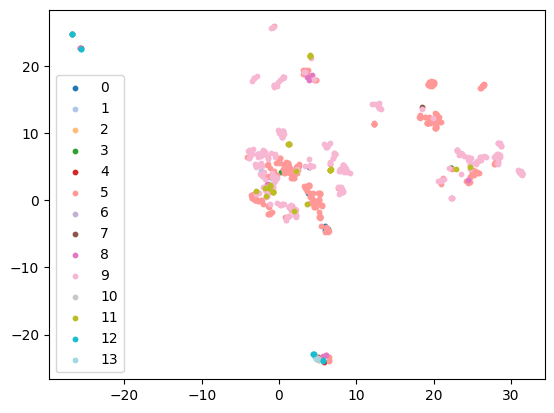

In [16]:
import matplotlib.pyplot as plt
import numpy as np 
# Get unique categories
categories = np.unique(results["v_gene_encoded"])

# Create a color map
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(categories)))

for i, category in enumerate(categories):
    # Create a boolean mask for the current category
    mask = results["v_gene_encoded"] == category

    # Plot the points for this category
    plt.scatter(results["UMAP_1"][mask], results["UMAP_2"][mask],cmap = "tab20",  color=colors[i], label=category, s=10)

plt.legend()
plt.show()

In [ ]:
from seqlp.visualize.comparative_analysis import Pipeline

In [ ]:
Pipe = Pipeline(model_path = r"C:\Users\nilsh\my_projects\ExpoSeq\models\nanobody_full")

Pipe.single_sequence(sequencing_report.head(1))

In [ ]:
print(collection_array.shape)

In [ ]:
import seaborn as sns

sns.heatmap(collection_array[0, :, :], )

In [ ]:
collection_array = run_pipeline(path_csv = r"C:\Users\nilsh\my_projects\ExpoSeq\my_experiments\max_new\sequencing_report.csv",
             number_sequences_per_group=1,
             muscle_path=r"C:\Users\nilsh\Downloads\muscle3.8.31_i86win32.exe",
             model_path = r"C:\Users\nilsh\my_projects\ExpoSeq\models\nanobody_full", )

In [ ]:
import seaborn as sns

sns.heatmap(collection_array[0, :, :], )